Our problematic is that density is really respected in our network as long as it evolves.  
We must, therefore, find rules such that it can work properly, having nice and realistic 2D representation.

In [1]:
from relaxablegpn import RelaxableGPN
from helper import *
import networkx as nx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import gc

In [2]:
def p_dupl():
    return np.random.random() > 0.46

In [3]:
def node_pos(node):
    x = node["dist_N"] / (node["dist_N"] + node["dist_S"])
    y = node["dist_E"] / (node["dist_E"] + node["dist_W"])
    x, y = (x - 0.5) * 1.5, (y - 0.5) * 1.5
    return np.array([x, y])

def embedded_viz(gpn, finetune=True):
    gpn.update_all_dist()
    # pos is a dict of np array with coordinates
    pos = {n: node_pos(gpn.G.nodes[n]) for n in gpn.G.nodes}
    if finetune:
        pos = pos = nx.spring_layout(gpn.G, pos=pos, k=0.01, iterations=1)
    return pos

def quick_export(gpn, pos, name, useful=None):
    global ignore_export
    if ignore_export:
        return
    gpn.update_all_dist()
    gpn.show_dist(pos=pos, figsize=(12, 12))
    color = {True: "green", False: "red"}.get(useful, "grey")
    rect = plt.Rectangle((-0.825, 0.750), 0.075, 0.075, fc=color)
    plt.gca().add_patch(rect)
    plt.savefig(name)
    plt.close()
    
def print_run(i):
    print()
    print("-" * 50)
    print()
    print(f"Run {i}")
    
def get_pathological_nodes_1(gpn):
    # delta dist with ngb >= 2 in one direction
    pathological_nodes = list()
    for n in gpn.G.nodes:
        ref = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
        # calc center of mass of ngbs
        for ngb in gpn.ngb(n):
            d = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
            if (d[0] >= ref[0] + 2) or (d[0] >= ref[0] + 2):
                pathological_nodes.append(n)
                break
            
    return pathological_nodes

def get_pathological_nodes_2(gpn):
    # center of gravity too much "out"
    pathological_nodes = list()
    for n in gpn.G.nodes:
        if gpn.is_border_node(n):
            continue
        c = np.array([0, 0])
        # calc center of mass of ngbs
        for i, ngb in enumerate(gpn.ngb(n)):
            node = gpn.G.nodes[ngb]
            c = c + node_pos(node)
        c = c[0] / (i + 1), c[1] / (i + 1)
        
        # compare
        node = gpn.G.nodes[n]
        ref = node_pos(node)
        dist = np.sqrt((c[0] - ref[0])**2 + (c[1] - ref[1])**2)

        if dist > 0.1:
            pathological_nodes.append(n)
            
    return pathological_nodes

def get_marginal_nodes(gpn, thr=1.1):
    test = (lambda x: x > thr) if thr > 1 else (lambda x: x < thr)
    mean_NS, mean_EW = gpn.mean_NS(), gpn.mean_EW()
    
    candidates = list()
    for n in gpn.G.nodes:
        node = gpn.G.nodes[n]
        val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
        val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
        if test(val_NS):
            candidates.append(n)

        if test(val_EW):
            candidates.append(n)
            
    return candidates

In [10]:
seed = 0
random.seed(seed)
np.random.seed(seed)
gpn = RelaxableGPN()
gpn.debug = False
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

root = "output/evonet12/"
ratio = 0
for i in range(2000):
    print_run(i)
    if i == 517:
        pass # break
    if p_dupl():
        ratio += 1
        gpn.duplicate_random()
    else:
        ratio -= 1
        gpn.destroy_random()
        
    if i % 100 in range(10):
        pos = embedded_viz(gpn, finetune=True)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    
    gpn.relax()
    
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    if i % 100 in range(10):
        pos = embedded_viz(gpn, finetune=True)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png")
    
    if i % 10 == 0 or True:
        gc.collect()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())


--------------------------------------------------

Run 0
Action
Score are for NS : 0.048383500691042344, EW : 0.048383500691042344, both : 0.03583683006102562, main : 0.4877390007352674
Quasi lonely node 49 with #ngbs = 2
Quasi lonely node 49 with #ngbs = 2
Quasi lonely node 49 with #ngbs = 2
Quasi lonely node 49 with #ngbs = 2
Quasi lonely node 49 with #ngbs = 2
Action ran : RelaxAction : build with (41, 64, 35), pattern is [('+', (41, 64))] : 1.1011306326809263
Score are for NS : 0.017543859649122806, EW : 0.048383500691042344, both : 0.028344358283489773, main : 0.3333476558944017

Iteration 0 ratio 1 density 0.08290816326530612

--------------------------------------------------

Run 1
Action
Score are for NS : 0.049360688301519066, EW : 0.04641668966779984, both : 0.03773067783095193, main : 0.6244602203369141
Action ran : RelaxAction : build with (49, 42, 36), pattern is [('+', (49, 42))] : 0.0
Score are for NS : 0.04529474910530199, EW : 0.029995009442280892, both : 0.02496755

Quasi lonely node 41 with #ngbs = 2
Action ran : RelaxAction : build with (75, 50, 37), pattern is [('+', (75, 50))] : 1.550657668435262
Score are for NS : 0.09517405697125508, EW : 0.09320632156378401, both : 0.06453102633668044, main : 5.252001963548878

--------------------------------------------------

Run 19
Action
Score are for NS : 0.13974203875093708, EW : 0.0891856598896788, both : 0.07834306037834775, main : 10.555773117688965
Quasi lonely node 1 with #ngbs = 2
Quasi lonely node 1 with #ngbs = 2
Quasi lonely node 1 with #ngbs = 2
Action ran : RelaxAction : build with (71, 17, 8), pattern is [('+', (71, 17))] : 7.2467560553633215
Score are for NS : 0.1376640251345597, EW : 0.0825782140664067, both : 0.07276795798574409, main : 8.935201644646256

--------------------------------------------------

Run 20
Action
Score are for NS : 0.13694570361424774, EW : 0.08095138398211661, both : 0.07777162001394669, main : 7.185417327403273
Quasi lonely node 18 with #ngbs = 2
Quasi lonely 

Action ran : RelaxAction : build with (67, 48, -1), pattern is [('+', (67, 48))] : 63.93551748898467
Score are for NS : 0.2020412351699432, EW : 0.0981823313953682, both : 0.11216437687031094, main : 24.79759863190476

--------------------------------------------------

Run 39
Action
Score are for NS : 0.20118631398960157, EW : 0.10013164180427388, both : 0.1130220665017694, main : 25.16824917123914
Action ran : None
Score are for NS : 0.20118631398960157, EW : 0.10013164180427388, both : 0.1130220665017694, main : 25.16824917123914

--------------------------------------------------

Run 40
Action
Score are for NS : 0.20909090909090908, EW : 0.11578712683021253, both : 0.12702038876440594, main : 44.31659327068884
Quasi lonely node 1 with #ngbs = 2
Quasi lonely node 1 with #ngbs = 2
Quasi lonely node 1 with #ngbs = 2
Action ran : RelaxAction : build with (88, 48, -1), pattern is [('+', (88, 48))] : 67.10479233555348
Score are for NS : 0.20114614118829752, EW : 0.09944057974097796, bot

Quasi lonely node 38 with #ngbs = 2
Action ran : RelaxAction : replace with ((50, 75), (43, 57)), pattern is [('+', (50, 75)), ('-', (43, 57))] : 2.053952835690336
Score are for NS : 0.1707297553397754, EW : 0.07641949542818065, both : 0.09091273681284355, main : 12.002828592475502

--------------------------------------------------

Run 60
Action
Score are for NS : 0.18116455224496622, EW : 0.07689914294447998, both : 0.09482097618248139, main : 14.635624485925925
Quasi lonely node 1 with #ngbs = 2
Quasi lonely node 1 with #ngbs = 2
Action ran : RelaxAction : replace with ((57, 50), (42, 57)), pattern is [('+', (57, 50)), ('-', (42, 57))] : 3.0254720000000024
Score are for NS : 0.17535936200385574, EW : 0.06216625473235777, both : 0.08384292467388738, main : 10.887238352592593

--------------------------------------------------

Run 61
Quasi lonely node 1 with #ngbs = 2
Action
Score are for NS : 0.1783526484179675, EW : 0.06321475554547519, both : 0.08590939255131792, main : 11.486311


--------------------------------------------------

Run 80
Action
Score are for NS : 0.19302684499811124, EW : 0.1190748618701288, both : 0.10659305273037868, main : 24.800345838188242
Action ran : None
Score are for NS : 0.19302684499811124, EW : 0.1190748618701288, both : 0.10659305273037868, main : 24.800345838188242

--------------------------------------------------

Run 81
Action
Score are for NS : 0.203668206854111, EW : 0.11866671694261861, both : 0.11255595002760149, main : 32.15038307379852
Action ran : None
Score are for NS : 0.203668206854111, EW : 0.11866671694261861, both : 0.11255595002760149, main : 32.15038307379852

--------------------------------------------------

Run 82
Action
Score are for NS : 0.20141609413390055, EW : 0.1326493810395339, both : 0.11701192175941075, main : 33.858078946361566
Action ran : RelaxAction : replace with ((57, 111), (75, 58)), pattern is [('+', (57, 111)), ('-', (75, 58))] : 11.14479311908566
Score are for NS : 0.19116815987134267, EW

Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Calling outside_with_anchor
debug_anchor {'next_': 54, 'prev': 63, 'current': 115, 'ngb2': 115, 'ngb1': 123, 'node': 63, 'self': <relaxablegpn.RelaxableGPN object at 0x7f99f8c30400>}
Action ran : RelaxAction : build with (123, 115, -1), pattern is [('+', (123, 115))] : 3.0763957890499967
Score are for NS : 0.23319689901844806, EW : 0.1304754071209935, both : 0.126338528520443, main : 35.87824638667181

--------------------------------------------------

Run 98
Action
Score are for NS : 0.23651736653505911, EW : 0.1328433588178071, both : 0.13139654883249358, main : 41.8885835463688
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Action ran : RelaxAction : replace with ((18, 16), (26, 16)), pattern is [('+', (18, 16

Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Action ran : RelaxAction : build with (122, 58, 147), pattern is [('+', (122, 58))] : 47.471305830469156
Score are for NS : 0.2306914066500467, EW : 0.09756336819957391, both : 0.11028946378863581, main : 21.3653512949912

--------------------------------------------------

Run 109
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Action
Score are for NS : 0.23113063091554736, EW : 0.09975062651236614, both : 0.112864881420817, main : 23.79304032921811
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Removing crossing border edge 107 47 (203, 208, 0)
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 86 with #

Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 117 with #ngbs = 2
Quasi lonely node 117 with #ngbs = 2
Action ran : RelaxAction : replace with ((47, 117), (54, 117)), pattern is [('+', (47, 117)), ('-', (54, 117))] : 16.36820909016193
Score are for NS : 0.1892645987766112, EW : 0.10284993159768678, both : 0.10868043989848829, main : 24.667174981730696

--------------------------------------------------

Run 116
Action
Score are for NS : 0.18559009130867296, EW : 0.09393890410814197, both : 0.10497202227574629, main : 21.394416338056686
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi l

Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 124 with #ngbs = 2
Action ran : RelaxAction : build with (12, 71, 9), pattern is [('+', (12, 71))] : 5.672685121906228
Score are for NS : 0.19482081337761184, EW : 0.07752753322022196, both : 0.09950209260210544, main : 15.84594420695332

--------------------------------------------------

Run 131
Action
Score are for NS : 0.19393237484301878, EW : 0.0809478047319789, both : 0.101034430291126, main : 18.78563600066645
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi 

Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 131 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Action ran : RelaxAction : build with (25, 126, 191), pattern is [('+', (25, 126))] : 23.549022941121464
Score are for NS : 0.17476856105309158, EW : 0.09535265975024772, both : 0.1044844226928063, main : 19.5636650120273

--------------------------------------------------

Run 144
Action
Score are for NS : 0.17386062076725292, EW : 0


--------------------------------------------------

Run 156
Action
Score are for NS : 0.1692088464439148, EW : 0.1065398413644251, both : 0.10920766991416063, main : 25.336397618391103
Action ran : None
Score are for NS : 0.1692088464439148, EW : 0.1065398413644251, both : 0.10920766991416063, main : 25.336397618391103

--------------------------------------------------

Run 157
Action
Score are for NS : 0.16985338162316854, EW : 0.10647712564511208, both : 0.10920600851688891, main : 25.356702880984095
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Quasi lonely node 139 with #ngbs = 2
Action ran : RelaxAction : build with (156, 91, 226), pattern is [('+', (156, 91))] : 18.3752943076439
Score are for NS : 0.16819750630663752, EW : 0.10270063139684822, both : 0.10606104964544609, main : 21.95503689112599

--------

Action ran : RelaxAction : build with (104, 16, 271), pattern is [('+', (104, 16))] : 16.042258071482564
Score are for NS : 0.15126037441467086, EW : 0.13189356406920047, both : 0.09747370046002221, main : 28.51493946658028

--------------------------------------------------

Run 171
Action
Score are for NS : 0.164673610060068, EW : 0.13198128102556175, both : 0.09867426569394189, main : 30.05432737560613
Action ran : None
Score are for NS : 0.164673610060068, EW : 0.13198128102556175, both : 0.09867426569394189, main : 30.05432737560613

--------------------------------------------------

Run 172
Action
Score are for NS : 0.16409190420572176, EW : 0.13920059333606852, both : 0.10161189045897209, main : 39.317545435616644
Action ran : None
Score are for NS : 0.16409190420572176, EW : 0.13920059333606852, both : 0.10161189045897209, main : 39.317545435616644

--------------------------------------------------

Run 173
Action
Score are for NS : 0.17230923260953024, EW : 0.138064992717646

Action ran : RelaxAction : build with (87, 82, -1), pattern is [('+', (87, 82))] : 10.202277980998835
Score are for NS : 0.12811712328566013, EW : 0.1290983334946394, both : 0.09941484368129995, main : 20.22657661257317

--------------------------------------------------

Run 194
Action
Score are for NS : 0.14563556158052535, EW : 0.13168329200471146, both : 0.10618587989150255, main : 29.775544582222203
Removing crossing border edge 170 87 (128, 327, 0)
Action ran : RelaxAction : replace with ((149, 104), (182, 16)), pattern is [('+', (149, 104)), ('-', (182, 16))] : 13.996519769055345
Score are for NS : 0.13178647448893635, EW : 0.12811017513197379, both : 0.09971398088685006, main : 20.193245589250772

--------------------------------------------------

Run 195
Action
Score are for NS : 0.1288220318044258, EW : 0.1287098333963464, both : 0.09850960365281305, main : 19.000503774760507
Action ran : None
Score are for NS : 0.1288220318044258, EW : 0.1287098333963464, both : 0.098509603

Quasi lonely node 100 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Action ran : RelaxAction : replace with ((108, 172), (99, 116)), pattern is [('+', (108, 172)), ('-', (99, 116))] : 12.094954802733646
Score are for NS : 0.13378626573051552, EW : 0.09572340116826922, both : 0.08207717173845781, main : 17.584920249031192

--------------------------------------------------

Run 209
Action
Score are for NS : 0.13345100770768228, EW : 0.09844400088247066, both : 0.08334228380146863, main : 17.845243632034517
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Action ran : RelaxAction : build with (145, 100, 137), pattern is [('+', (145, 100))] : 57.81625115420125
Score are for NS : 0.13071431198902292, EW : 0.09748087131202224, both : 0.08097573192026702, main : 14.160963619177377

--------------------------------------------------

Run 210
Action
Scor

--------------------------------------------------

Run 232
Action
Score are for NS : 0.14355871940195686, EW : 0.14652655482161234, both : 0.11227558541695006, main : 67.14373484995133
Quasi lonely node 193 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 192 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 192 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 192 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Quasi lonely node 192 with #ngbs = 2
Quasi lonely node 185 with #ngbs = 2
Action ran : RelaxAction : build with (81, 186, 321), pattern is [('+', (81, 186))] : 33.5868748277013
Score are for NS : 0.13513076735365012, EW : 0.14745676600536922, both : 0.1097477329610655, main : 59.557962380163545

--------------------------------------------------

Run 233
Action
Score are for NS : 0.13467177840889027, EW 


--------------------------------------------------

Run 245
Action
Score are for NS : 0.14080963057421222, EW : 0.16121932931729463, both : 0.12378137519155025, main : 83.21324765624999
Quasi lonely node 5 with #ngbs = 2
Action ran : RelaxAction : replace with ((167, 181), (211, 87)), pattern is [('+', (167, 181)), ('-', (211, 87))] : 2.636937500000002
Score are for NS : 0.11920811796369472, EW : 0.16148633849617933, both : 0.11816304716615993, main : 67.04434024884259

--------------------------------------------------

Run 246
Action
Score are for NS : 0.11513248454140855, EW : 0.16245826318489043, both : 0.11663472217362633, main : 64.59085588816664
Action ran : RelaxAction : build with (195, 172, -1), pattern is [('+', (195, 172))] : 13.080631560582717
Score are for NS : 0.1111755803710421, EW : 0.16163870960961513, both : 0.11448362328298313, main : 60.80556783208762

--------------------------------------------------

Run 247
Quasi lonely node 213 with #ngbs = 2
Action
Score are

Quasi lonely node 211 with #ngbs = 2
Quasi lonely node 211 with #ngbs = 2
Quasi lonely node 211 with #ngbs = 2
Removing crossing border edge 116 216 (361, 451, 0)
Action ran : RelaxAction : replace with ((114, 104), (91, 16)), pattern is [('+', (114, 104)), ('-', (91, 16))] : 14.055721841813911
Score are for NS : 0.15214789767457912, EW : 0.17143874613679944, both : 0.12972460164703278, main : 70.68840513883448

--------------------------------------------------

Run 264
Action
Score are for NS : 0.15150012248654587, EW : 0.17370380070862826, both : 0.130824324130079, main : 73.89021231432599
Action ran : None
Score are for NS : 0.15150012248654587, EW : 0.17370380070862826, both : 0.130824324130079, main : 73.89021231432599

--------------------------------------------------

Run 265
Action
Score are for NS : 0.16338484144495832, EW : 0.18643540878835638, both : 0.13920799776195872, main : 99.13211960921194
Calling outside_with_anchor
debug_anchor {'next_': 191, 'prev': 47, 'current':

Action ran : RelaxAction : replace with ((187, 3), (170, 187)), pattern is [('+', (187, 3)), ('-', (170, 187))] : 5.972758149606092
Score are for NS : 0.1427917638804138, EW : 0.11790681228458684, both : 0.09316093661421039, main : 22.418011707274367

--------------------------------------------------

Run 280
Action
Score are for NS : 0.14954872954131973, EW : 0.11712230373481029, both : 0.09339613690303815, main : 24.197176047827163
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 86 with #ngbs = 2
Action ran : RelaxAction : build with (225, 16, 477), pattern is [('+', (225, 16))] : 11.180037807183364
Score are for NS : 0.14954872954131973, EW : 0.11661020483317032, both : 0.09339126813666217, main : 24.093742866842238

--------------------------------------------------

Run 281
Action
Score are f

Action ran : RelaxAction : replace with ((206, 116), (119, 206)), pattern is [('+', (206, 116)), ('-', (119, 206))] : 9.615045287362872
Score are for NS : 0.16938020891595865, EW : 0.10556995964428911, both : 0.09039960693083614, main : 21.69670503284012

--------------------------------------------------

Run 299
Action
Score are for NS : 0.1556899602309103, EW : 0.10603567085971864, both : 0.08822471843900681, main : 19.01314755987495
Action ran : RelaxAction : replace with ((65, 116), (172, 116)), pattern is [('+', (65, 116)), ('-', (172, 116))] : 8.887353657981054
Score are for NS : 0.15415958317107376, EW : 0.10109799406307679, both : 0.08889422323267288, main : 18.835619804512604

--------------------------------------------------

Run 300
Action
Score are for NS : 0.15797711285516453, EW : 0.10176944611026315, both : 0.09172920828789508, main : 20.400545507755872
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 130 with #ngbs = 2
Quasi lonely node 234 with #ngbs = 2
Quasi 

Quasi lonely node 234 with #ngbs = 2
Quasi lonely node 234 with #ngbs = 2
Quasi lonely node 242 with #ngbs = 2
Action ran : RelaxAction : replace with ((16, 139), (225, 16)), pattern is [('+', (16, 139)), ('-', (225, 16))] : 8.238755176514019
Score are for NS : 0.180582457040739, EW : 0.12669738874674663, both : 0.10932657778011222, main : 39.19464346560984

--------------------------------------------------

Run 318
Action
Score are for NS : 0.18001802824560642, EW : 0.12483141413293221, both : 0.10821589776367592, main : 39.18701334217442
Action ran : RelaxAction : replace with ((4, 165), (138, 4)), pattern is [('+', (4, 165)), ('-', (138, 4))] : 30.852290784353045
Score are for NS : 0.17870646607175936, EW : 0.1239263173173338, both : 0.10786645719385404, main : 38.872256521778596

--------------------------------------------------

Run 319
Action
Score are for NS : 0.1799192975497519, EW : 0.12686119112930005, both : 0.11120383359813701, main : 45.160805393187516
Action ran : Relax

Score are for NS : 0.18730818747503208, EW : 0.12855548568845918, both : 0.12109404085099632, main : 67.59201029727595

--------------------------------------------------

Run 343
Action
Score are for NS : 0.1881568730534383, EW : 0.1282541119755742, both : 0.12125313385049567, main : 68.09022816737134
Action ran : None
Score are for NS : 0.1881568730534383, EW : 0.1282541119755742, both : 0.12125313385049567, main : 68.09022816737134

--------------------------------------------------

Run 344
Action
Score are for NS : 0.18629794656474966, EW : 0.12873216263610932, both : 0.12181169018565711, main : 68.78878199077383
Action ran : None
Score are for NS : 0.18629794656474966, EW : 0.12873216263610932, both : 0.12181169018565711, main : 68.78878199077383

--------------------------------------------------

Run 345
Action
Score are for NS : 0.20323552633523861, EW : 0.12921526331834, both : 0.1304112792879616, main : 77.39960264613458
Action ran : None
Score are for NS : 0.203235526335238


--------------------------------------------------

Run 364
Quasi lonely node 259 with #ngbs = 2
Action
Score are for NS : 0.18060556338751554, EW : 0.13046106425180765, both : 0.10978095468946289, main : 25.020327258703936
Quasi lonely node 259 with #ngbs = 2
Quasi lonely node 259 with #ngbs = 2
Quasi lonely node 259 with #ngbs = 2
Quasi lonely node 259 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Quasi lonely node 223 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 

--------------------------------------------------

Run 378
Quasi lonely node 216 with #ngbs = 2
Action
Score are for NS : 0.18416192354076877, EW : 0.15542956706045535, both : 0.14330426384799821, main : 61.028169818131346
Action ran : None
Score are for NS : 0.18416192354076877, EW : 0.15542956706045535, both : 0.14330426384799821, main : 61.028169818131346

--------------------------------------------------

Run 379
Action
Score are for NS : 0.1677072933759069, EW : 0.15483741770000445, both : 0.13448989286883672, main : 46.07529586916184
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 259 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 223 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lo

Quasi lonely node 239 with #ngbs = 2
Action ran : RelaxAction : build with (41, 167, 513), pattern is [('+', (41, 167))] : 15.860272444233365
Score are for NS : 0.1655662067763535, EW : 0.13994599742645528, both : 0.13013385517839768, main : 29.924936542905385

--------------------------------------------------

Run 388
Action
Score are for NS : 0.16033909835078053, EW : 0.14463851564020005, both : 0.1293351893772943, main : 30.424840335101425
Quasi lonely node 268 with #ngbs = 2
Quasi lonely node 268 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 268 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Quasi lonely node 239 with #ngbs = 2
Quasi lonely node 268 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 254 with #ngbs = 2
Action ran : RelaxAction : replace with ((165, 199), (1, 4)), pattern is [('+', (165, 199)), ('-', (1, 4))] : 27.57561769774153
Score are for NS : 0.15940969868954882, EW : 0.1415071

Action ran : RelaxAction : replace with ((276, 16), (199, 273)), pattern is [('+', (276, 16)), ('-', (199, 273))] : 1.1663311999155686
Score are for NS : 0.1251057033576638, EW : 0.1500349962612372, both : 0.11612161610242801, main : 20.69474293890159

--------------------------------------------------

Run 400
Action
Score are for NS : 0.12411398236424265, EW : 0.1526463415973853, both : 0.11774085206910147, main : 20.898614776623823
Action ran : RelaxAction : build with (278, 5, 510), pattern is [('+', (278, 5))] : 17.220080345452473
Score are for NS : 0.12246699759057571, EW : 0.1499534027995623, both : 0.11516019453234502, main : 19.223150792970706

Iteration 400 ratio 37 density 0.20867768595041322

--------------------------------------------------

Run 401
Action
Score are for NS : 0.11943571337469006, EW : 0.15088875502130908, both : 0.11315830668046707, main : 18.733450214561255
Action ran : RelaxAction : replace with ((270, 82), (226, 187)), pattern is [('+', (270, 82)), ('-'

Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 198 with #ngbs = 2
Quasi lonely node 198 with #ngbs = 2
Action ran : RelaxAction : replace with ((49, 239), (130, 24)), pattern is [('+', (49, 239)), ('-', (130, 24))] : 21.3922084326457
Score are for NS : 0.16928721582588963, EW : 0.19460687283378517, both : 0.16186270607355524, main : 66.92836280803208

--------------------------------------------------

Run 418
Action
Score are for NS : 0.16231281348794524, EW : 0.1937081144227776, both : 0.15509877141818162, main : 58.180971561054946
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Action ran : RelaxAction : replace with ((276, 275), (199, 4)), pattern is [('+', (276, 275)), ('-', (199, 4))] : 22.081013778707707
Score are for NS : 0.16129246800813735, EW : 0.193729221258884, both : 0.1547744264141233, main : 57.765774120438486

--------------------------------------------------

Run 419
Quasi lonely node 216 with #ng


--------------------------------------------------

Run 440
Action
Score are for NS : 0.19557072578932602, EW : 0.23185439215564704, both : 0.18419748092504998, main : 94.00096446159864
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 286 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 263 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 263 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 286 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 286 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 129 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 286 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2


--------------------------------------------------

Run 459
Quasi lonely node 236 with #ngbs = 2
Action
Score are for NS : 0.2103354844583318, EW : 0.30530827469274174, both : 0.2247483862188048, main : 154.33489926656085
Action ran : None
Score are for NS : 0.2103354844583318, EW : 0.30530827469274174, both : 0.2247483862188048, main : 154.33489926656085

--------------------------------------------------

Run 460
Quasi lonely node 268 with #ngbs = 2
Action
Score are for NS : 0.21151715889406292, EW : 0.3036849805815875, both : 0.22394045642512317, main : 152.83594226863767
Quasi lonely node 285 with #ngbs = 2
Quasi lonely node 285 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 293 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 263 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 293 with #ngbs = 2
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 293 with #ngbs = 2
Quasi lone


--------------------------------------------------

Run 483
Action
Score are for NS : 0.2003777151617898, EW : 0.2433665543582638, both : 0.19856402257501324, main : 112.30872633999999
Action ran : None
Score are for NS : 0.2003777151617898, EW : 0.2433665543582638, both : 0.19856402257501324, main : 112.30872633999999

--------------------------------------------------

Run 484
Action
Score are for NS : 0.2008392722315294, EW : 0.24389280171877892, both : 0.19925193624022625, main : 113.76600147831451
Action ran : None
Score are for NS : 0.2008392722315294, EW : 0.24389280171877892, both : 0.19925193624022625, main : 113.76600147831451

--------------------------------------------------

Run 485
Action
Score are for NS : 0.19282896508132405, EW : 0.24434787159486604, both : 0.1970001833448151, main : 114.73925652763309
Action ran : None
Score are for NS : 0.19282896508132405, EW : 0.24434787159486604, both : 0.1970001833448151, main : 114.73925652763309

-----------------------------


--------------------------------------------------

Run 503
Quasi lonely node 96 with #ngbs = 2
Action
Score are for NS : 0.23793280380964554, EW : 0.2687531057102491, both : 0.22946949688357277, main : 153.18993855989135
Action ran : None
Score are for NS : 0.23793280380964554, EW : 0.2687531057102491, both : 0.22946949688357277, main : 153.18993855989135

--------------------------------------------------

Run 504
Quasi lonely node 232 with #ngbs = 2
Action
Score are for NS : 0.24634449790268856, EW : 0.2699354918865061, both : 0.23463887500167113, main : 167.52190251133771
Action ran : None
Score are for NS : 0.24634449790268856, EW : 0.2699354918865061, both : 0.23463887500167113, main : 167.52190251133771

--------------------------------------------------

Run 505
Quasi lonely node 96 with #ngbs = 2
Action
Score are for NS : 0.2611909520156446, EW : 0.27008428628667813, both : 0.23907690982644034, main : 188.21065824
Quasi lonely node 311 with #ngbs = 2
Quasi lonely node 311 wit

ValueError: 640 is not in list

In [13]:
gpn.ngb(238)

[307, 316]

In [15]:
gpn.dual_cycle_pairs(203)

{111: (598, 526, 0), 327: (526, 598, 1)}

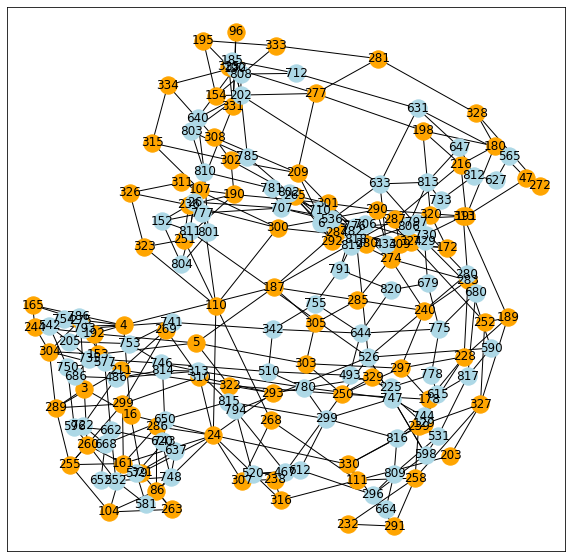

In [7]:
gpn.show_all()

In [9]:
gpn.D.nodes[640]

{'ngb': [(640, -1, 0),
  (640, 190, 0),
  (640, 202, 0),
  (803, 640, 0),
  (640, 810, 1)]}

In [16]:
gpn.planar_cycle_pairs(640)

{(640, -1, 0): (107, 331),
 (640, 190, 0): (331, 332),
 (640, 202, 0): (332, 334),
 (803, 640, 0): (334, 315),
 (640, 810, 1): (315, 107)}

In [8]:
gc.collect()

14383

In [ ]:
raise

Quasi lonely node 203 with #ngbs = 2
Quasi lonely node 329 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 329 with #ngbs = 2
{'ls_to_update': [(823, 190, 1), (823, 190, 0), (640, 190, 0)], 'dual_current': 190, 'new_edge': (823, 190, 1), 'idx': 1, 'current_edge': (823, 190), 'dual_edge': (823, -1, 1), 'planar_edge': (331, 325), 'c_idx': 6, 'current': 331, 'split_ngb_2': 107, 'split_ngb_1': 277, 'new_node': 823, 'edge': (640, 803, 1), 'map_ingb_pair': {334: (334, 315), 315: (315, 107), 107: (107, 331), 331: (331, 325), 332: (332, 96), 96: (96, 331), 325: (325, 277), 277: (277, 209), 209: (209, 308), 308: (308, 334)}, 'ingbs': [334, 315, 107, 331, 332, 96, 331, 325, 277, 209, 308], 'ordered_cycle_pairs': [(334, 315), (315, 107), (107, 331), (331, 332), (332, 96), (96, 331), (331, 325), (325, 277), (277, 209), (209, 308), (308, 334)], 'nb_ngbs': 11, 'ngb_edges': [(803, 640, 0), (640, 810, 1), (640, -1, 0), (640, 190, 0), (640, 190, 1), (640, 190, 2), (640, -1, 1), (640, 808, 0), (640, 633, 0), (640, 785, 0), (640, 803, 1)], 'Z': [(801, -1, 0), (565, -1, 2), (-1, 565, 1), (-1, 631, 0), (-1, 712, 0), (819, -1, 0), (627, -1, 0), (185, -1, 0), (-1, 808, 0), (823, -1, 1), (733, -1, 0), (-1, 620, 0), (794, -1, 0), (741, -1, 0), (-1, 755, 0), (823, -1, 0), (577, -1, 0)], 'min_pair': (277, 107), 'dual_node': 640, 'self': <relaxablegpn.RelaxableGPN object at 0x7f99f7d45c18>, 'map_edge_pair': {(803, 640, 0): (334, 315), (640, 810, 1): (315, 107), (640, -1, 0): (107, 331), (640, 190, 0): (331, 332), (640, 190, 1): (332, 96), (640, 190, 2): (96, 331), (640, -1, 1): (331, 325), (640, 808, 0): (325, 277), (640, 633, 0): (277, 209), (640, 785, 0): (209, 308), (640, 803, 1): (308, 334)}}

In [ ]:
doer = gpn.copy()
(21, 13) in doer.G.edges
# doer.show_all()

In [ ]:
doer = gpn.copy()
doer.check_all()
doer.build_new_edge(*args)

In [ ]:
args = (21, 13, 12)

## Rollback

In [ ]:
seed = 2
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(150):
    print_run(i)
    if i < 100:
        if p_dupl():
            ratio += 1
            gpn.duplicate_random()
        else:
            ratio -= 1
            gpn.destroy_random()
        
    pos = embedded_viz(gpn)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    back = gpn.copy()

    if gpn.shorten_dist():
        pos = embedded_viz(gpn)
        print("Shorten")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png", useful=sc < dist_score)
            dist_score = sc
            
    back = gpn.copy()

    if gpn.maxen_dist():
        pos = embedded_viz(gpn)
        print("Maxen")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png", useful=sc < dist_score)
            dist_score = sc
        
    if gpn.remove_useless_edge():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_d.png")
        print("AAAAAAAAAAAAAA - Remuseless")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

In [ ]:
lA, lB, lC = gpn.get_all_dists()
plt.subplot(3, 1, 1)
plt.hist(lA)
plt.subplot(3, 1, 2)
plt.hist(lB)
plt.subplot(3, 1, 3)
plt.hist(lC)

In [ ]:
raise

In [ ]:
for x in [(-1, 117, 1), (117, 118, 0), (118, 47, 0), (-1, 120, 0), (120, 47, 0)]:
    print(gpn.dual(x))

In [ ]:
gpn.G.nodes[9], gpn.G.nodes[8], gpn.G.nodes[0]

In [ ]:
gpn.show_all()

In [ ]:
pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
gpn.update_all_dist()
gpn.show_dist(pos=pos, figsize=(8, 8))

In [ ]:
gpn.dual((125, 15)), gpn.ngb(15), gpn.ngb(7), gpn.dual((125, 7))

In [ ]:
raise

In [ ]:
list_inner = [gpn.G.degree(n) for n in gpn.G.nodes if not gpn.is_border_node(n)]
list_outer = [gpn.G.degree(n) for n in gpn.G.nodes if gpn.is_border_node(n)]

In [ ]:
plt.hist(list_inner)

In [ ]:
plt.hist(list_outer)

In [ ]:
gpn.show_all()

In [ ]:
raise

In [ ]:
# test 1
def test_func():
    gpn = GrowingPlanarNetwork()
    gpn.init_square(8)
    for i in range(500):
        if p_dupl():
            gpn.duplicate_random_node()
        else:
            gpn.remove_random_node()
    dist = np.array(list(nx.betweenness_centrality(gpn.G).values()))
    return (skew(dist), kurtosis(dist), gpn.G, gpn.D)

for i in range(10):
    S, K, G, D = test_func()
    print(G.size(), D.degree(-1))

In [ ]:
G = gpn.G

In [ ]:
pos = nx.spring_layout(G, k=0.1, iterations=50)
pos = nx.planar_layout(gpn.G)
plt.figure(figsize=(12, 12))
nx.draw_networkx(gpn.G, pos=pos)

In [ ]:
pos = nx.planar_layout(Gstart)
plt.figure(figsize=(12, 12))
nx.draw_networkx(Gstart, pos=pos)

In [ ]:
raise

In [ ]:
gpn.show_all()

In [ ]:
ls_ngb = [len(gpn.ngb(x)) for x in gpn.G.nodes]

In [ ]:
plt.hist(ls_ngb)

In [ ]:
raise

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb

In [ ]:
gpn.stabilize_ngb(10)

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb